In [1]:
#reset
import pickle

day = 1
WY = []
ratesave = []

with open("day1.pkl","wb") as f:
 pickle.dump(day, f)

with open("ratedata1.pkl","wb") as f:
 pickle.dump(WY, f)
    
with open("ratesave1.pkl","wb") as f:
 pickle.dump(ratesave, f)

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
2022-08-09 19:34:02.905 python[2551:12459] mac-virtualcam(DAL): PlugInMain version=1.3.0
2022-08-09 19:34:02.905 python[2551:12459] mac-virtualcam(DAL): HardwarePlugIn_QueryInterface 
2022-08-09 19:34:02.905 python[2551:12459] mac-virtualcam(DAL): HardwarePlugIn_Release sRefCount now = 0
2022-08-09 19:34:02.906 python[2551:12459] mac-virtualcam(DAL): HardwarePlugIn_InitializeWithObjectID self=0x16d6bf478
2022-08-09 19:34:02.906 python[2551:12459] mac-virtualcam(DAL): HardwarePlugIn_ObjectSetPropertyData OBSDALDevice(36) kCMIOObjectPropertyListenerAdded self=0x16d6bf478 data(int)=1684629094
2022-08-09 19:34:02.906 python[2551:12459] mac-virtualcam(DAL): HardwarePlugIn_ObjectSetPropertyData OBSDALDevice(36) kCMIOObjectPropertyListenerAdded self=0x16d6bf478 data(int)=1869180523
2022-08-09 19:34:02.907 python[2551:12459] mac-virtualcam(DAL): HardwarePlugIn_ObjectSetPropertyData OBSDALDevice(36) kCMIOObjectPropertyListenerAdded self=0x

0
평균0.0
1
평균0.5


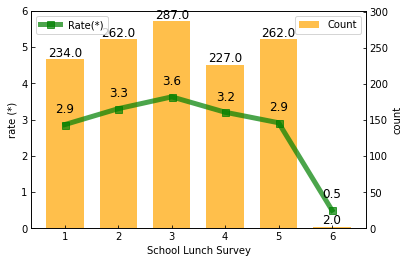

In [1]:
import pandas as pd
import cv2
import mediapipe as mp
import numpy as np
from openpyxl import Workbook
import matplotlib.ticker as plt
import matplotlib.pyplot as plt
import pickle
from playsound import playsound

#hands
max_num_hands = 1

#for rate system
l = []
rate = 0
rate_count = 0
count = 0
rateever = 0
ever = ""
ratecounter = ""

ever = "Aver : %0.1f" % rateever
ratecounter = "count : %i" % rate_count

#for xel
xel = pd.read_excel('sample.xlsx', engine='openpyxl')
w_wb = Workbook()
w_ws = w_wb.active

#graph & data save
WX = []
WY = []

'''
plt.title("School Lunch Survey (Unit: point)")
plt.xlabel("DATE")
plt.ylabel("RATE")
plt.ylim([0, 6])
#plt.xlim([1, 5])
#plt.gca().yaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f'))
'''


with open("day1.pkl","rb") as f:
    day = pickle.load(f)
    
for i in range(day):
    WX.append(i+1)

day += 1

with open("day1.pkl","wb") as f:
    pickle.dump(day, f)
    
with open("ratedata1.pkl","rb") as f:
    WY = pickle.load(f)

with open("ratesave1.pkl","rb") as f:
    ratesave= pickle.load(f)
    
RL = 0

x,y,w,h = 0,150,400,75

gesture = {
    0:'fist', 1:'one', 2:'two', 3:'three', 4:'four', 5:'five',
    6:'six', 7:'rock', 8:'spiderman', 9:'yeah', 10:'ok',
}

rate_gesture = {
    1:'one', 2:'two', 9:'two', 3:'three', 4:'four', 5:'five',
}

# MediaPipe hands model
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
hands = mp_hands.Hands(
    max_num_hands=max_num_hands,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5)

# Gesture recognition model
file = np.genfromtxt('data/gesture_train.csv', delimiter=',')
angle = file[:,:-1].astype(np.float32)
label = file[:, -1].astype(np.float32)
knn = cv2.ml.KNearest_create()
knn.train(angle, cv2.ml.ROW_SAMPLE, label)

cap = cv2.VideoCapture(1)

cap.set(cv2.CAP_PROP_FRAME_WIDTH, 2560)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 1600)

while cap.isOpened():
    ret, img = cap.read()
    ret, frame = cap.read()
    if not ret:
        continue

    img = cv2.flip(img, 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    result = hands.process(img)

    cv2.rectangle(img, (x, x), (x + w, y + h), (0,0,0), -1)    
    cv2.putText(img, ever, (0, 80), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 0, 255))
    cv2.putText(img, ratecounter, (0, 180), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 0, 255))
    
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

    if result.multi_hand_landmarks is not None:
        rate_result = []

        for res in result.multi_hand_landmarks:
            joint = np.zeros((21, 3))
            for j, lm in enumerate(res.landmark):
                joint[j] = [lm.x, lm.y, lm.z]
            
            # Compute angles between joints
            v1 = joint[[0,1,2,3,0,5,6,7,0,9,10,11,0,13,14,15,0,17,18,19],:] # Parent joint
            v2 = joint[[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],:] # Child joint
            v = v2 - v1 # [20,3]
            # Normalize v
            v = v / np.linalg.norm(v, axis=1)[:, np.newaxis]

            # Get angle using arcos of dot product
            angle = np.arccos(np.einsum('nt,nt->n',
                v[[0,1,2,4,5,6,8,9,10,12,13,14,16,17,18],:], 
                v[[1,2,3,5,6,7,9,10,11,13,14,15,17,18,19],:])) # [15,]

            angle = np.degrees(angle) # Convert radian to degree

            # Inference gesture
            data = np.array([angle], dtype=np.float32)
            ret, results, neighbours, dist = knn.findNearest(data, 3)
            idx = int(results[0][0])

            
            # Draw gesture result
            if idx in rate_gesture.keys():
                org = (int(res.landmark[0].x * img.shape[1]), int(res.landmark[0].y * img.shape[0]))
                cv2.putText(img, text=rate_gesture[idx].upper(), org=(org[0], org[1] + 20), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(255, 255, 255), thickness=2)

                rate_result.append({
                    'rate': rate_gesture[idx],
                    'org': org
                })
            
            

            mp_drawing.draw_landmarks(img, res, mp_hands.HAND_CONNECTIONS)

            
            if len(rate_result) >= 1:
                count = 0
                winner = None
                text = ''

                if rate_result[0]['rate']=='one':
                    rate = 1
                if rate_result[0]['rate']=='two':
                    rate = 2
                if rate_result[0]['rate']=='three':
                    rate = 3
                if rate_result[0]['rate']=='four':
                    rate = 4
                if rate_result[0]['rate']=='five':
                    rate = 5
                else :
                    rate = rate
                    
            if len(rate_result) == 0:
                if count == 0:
                    playsound("sound/fx1.wav", False)
                    
                    l.append(rate)
                    w_ws.append([rate])
                    w_wb.save('sample.xlsx')
                    print(rate)
                    rate_count += 1
                    xel = pd.read_excel('sample.xlsx', engine='openpyxl')
                    
                    #print rate ever
                    rateever = sum(l)/rate_count
                    ever = "ever : %0.1f" % rateever
                    ratecounter = "count : %i" % rate_count
                    print(f'평균{rateever}')
                    
                    #drawing graph
                    
                    if RL == 0 :
                        WY.append(rateever)
                        RL+=1
                    else :
                        WY[-1] = rateever
                    
                    with open("ratedata1.pkl","wb") as f:
                        pickle.dump(WY, f)
                    
                    count += 1
            
            
    cv2.imshow('rate', img)
    if cv2.waitKey(1) == ord('q'):
        
        '''
        plt.title("School Lunch Survey (Unit: point)")
        plt.xlabel("DATE")
        plt.ylabel("RATE")
        plt.ylim([0, 6])
        plt.plot(WX, WY, marker='*', label='week1', linestyle='--')
        for k in range(len(WX)):
            height = WY[k]
            plt.text(WX[k], height + 0.25, '%.1f' %height, ha='center', va='bottom', size = 12)
        plt.grid(True, axis='y', color='red', alpha=0.5)
        
        
        WX1 = WX
        plt.title("School Lunch Survey")
        plt.xlabel("DATE")
        plt.ylabel("count")
        plt.bar(WX1, ratesave)
        bar = plt.bar(WX1, ratesave)
        for rect in bar:
            height = rect.get_height()
            plt.text(rect.get_x() + rect.get_width()/2.0, height, '%.1f' % height, ha='center', va='bottom', size = 12)
        '''
        
        ratesave.append(rate_count)
        
        
        fig, ax1 = plt.subplots()

        ax1.plot(WX, WY, '-s', color='green', markersize=7, linewidth=5, alpha=0.7, label='Rate(*)')
        ax1.set_ylim(0.0, 6.0)
        ax1.set_xlabel('School Lunch Survey')
        ax1.set_ylabel('rate (*)')
        ax1.tick_params(axis='both', direction='in')
        for k in range(len(WX)):
            height = WY[k]
            ax1.text(WX[k], height + 0.25, '%.1f' %height, ha='center', va='bottom', size = 12)

        ax2 = ax1.twinx()
        bar = ax2.bar(WX, ratesave, color='orange', label='Count', alpha=0.7, width=0.7)
        #ax2.set_ylim(0, 18)
        ax2.set_ylabel('count')
        ax2.tick_params(axis='y', direction='in')

        #bar = plt.bar(WX, ratesave)
        for rect in bar:
            height = rect.get_height()
            ax2.text(rect.get_x() + rect.get_width()/2.0, height, '%.1f' % height, ha='center', va='bottom', size = 12)

        ax1.set_zorder(ax2.get_zorder() + 10)
        ax1.patch.set_visible(False)

        ax1.legend(loc='upper left')
        ax2.legend(loc='upper right')

        '''
        plt.grid(True, axis='x')
        plt.grid(True, axis='y')
        '''
        
        plt.show()
        break 

with open("ratesave1.pkl","wb") as f:
    pickle.dump(ratesave, f)
    
#print(xel)
cap.release()
cv2.destroyAllWindows()

In [ ]:
print(WX, WY, sep='-')

In [ ]:
print(ratesave)

In [ ]:
plt.bar(WX, ratesave)

In [28]:
print(ratecounter)

NameError: name 'ratecounter' is not defined

In [3]:
#graph chart
import numpy as np
import matplotlib.ticker as plt
import matplotlib.pyplot as plt
from openpyxl import Workbook
import pickle
%matplotlib

WX = []
WY = []

with open("day1.pkl","rb") as f:
    day = pickle.load(f)
    
for i in range(day-1):
    WX.append(i+1)


WY = [3.8, 4.0, 4.2, 4.1, 4.0]

ratesave= [261, 277, 312, 314, 325]

days = ['7/11[Mon]', '7/12[Tue]', '7/13[Wed]', '7/14[Thu]', '7/15[Fri]']
fig, ax1 = plt.subplots()

ax1.plot(WX, WY, '-s', color='green', markersize=7, linewidth=5, alpha=0.7, label='Rate[MAX:5]')
ax1.set_ylim(0.0, 6.0)
ax1.set_xlabel('School Lunch Survey 2022')
ax1.set_ylabel('Rate Average [MAX : 5]')
ax1.tick_params(axis='both', direction='in')
for k in range(len(WX)):
    height = WY[k]
    ax1.text(WX[k], height + 0.25, '%.1f' %height, ha='center', va='bottom', size = 12)

ax2 = ax1.twinx()
bar = ax2.bar(WX, ratesave, color='orange', label='Participation', alpha=0.7, width=0.7)
ax2.set_ylim(0, 350)
ax2.set_ylabel('Participation')
ax2.tick_params(axis='y', direction='in')

#bar = plt.bar(WX, ratesave)
for rect in bar:
    height = rect.get_height()
    ax2.text(rect.get_x() + rect.get_width()/2.0, height, '%.1f' % height, ha='center', va='bottom', size = 12)

ax1.set_zorder(ax2.get_zorder() + 10)
ax1.patch.set_visible(False)

plt.xticks(WX, days)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

'''
plt.grid(True, axis='x')
plt.grid(True, axis='y')
'''
plt.show()

Using matplotlib backend: MacOSX


ValueError: x and y must have same first dimension, but have shapes (8,) and (5,)

In [3]:
print(WY)

[2.8632478632478633, 3.301526717557252, 3.6271777003484322]


In [18]:
print(ratesave)

[234]


In [24]:
print(WX)

[1]


In [4]:
#graph chart
import numpy as np
import matplotlib.ticker as plt
import matplotlib.pyplot as plt
from openpyxl import Workbook
import pickle
%matplotlib

WX = []
WY = []

with open("day1.pkl","rb") as f:
    day = pickle.load(f)
    
for i in range(day-1):
    WX.append(i+1)

with open("ratedata1.pkl","rb") as f:
    WY = pickle.load(f)

with open("ratesave1.pkl","rb") as f:
    ratesave= pickle.load(f)

days = ['6/20[Mon]', '6/21[Tue]', '6/22[Wed]', '6/23[Thu]', '6/24[Fri]']
fig, ax1 = plt.subplots()

ax1.plot(WX, WY, '-s', color='green', markersize=7, linewidth=5, alpha=0.7, label='Rate[MAX:5]')
ax1.set_ylim(0.0, 6.0)
ax1.set_xlabel('School Lunch Survey 2022')
ax1.set_ylabel('Rate Average [MAX : 5]')
ax1.tick_params(axis='both', direction='in')
for k in range(len(WX)):
    height = WY[k]
    ax1.text(WX[k], height + 0.25, '%.1f' %height, ha='center', va='bottom', size = 12)

ax2 = ax1.twinx()
bar = ax2.bar(WX, ratesave, color='orange', label='Participation', alpha=0.7, width=0.7)
#ax2.set_ylim(0, 18)
ax2.set_ylabel('Participation')
ax2.tick_params(axis='y', direction='in')

#bar = plt.bar(WX, ratesave)
for rect in bar:
    height = rect.get_height()
    ax2.text(rect.get_x() + rect.get_width()/2.0, height, '%.1f' % height, ha='center', va='bottom', size = 12)

ax1.set_zorder(ax2.get_zorder() + 10)
ax1.patch.set_visible(False)

plt.xticks(WX, days)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

'''
plt.grid(True, axis='x')
plt.grid(True, axis='y')
'''
plt.show()

Using matplotlib backend: MacOSX


: 

In [5]:
import pandas as pd
import cv2
import mediapipe as mp
import numpy as np
from openpyxl import Workbook
import matplotlib.ticker as plt
import matplotlib.pyplot as plt
import pickle
from playsound import playsound

#hands
max_num_hands = 1

#for rate system
l = []
rate = 0
rate_count = 0
count = 0
rateever = 0
ever = ""
ratecounter = ""

ever = "ever : %0.1f" % rateever
ratecounter = "count : %i" % rate_count

#for xel
xel = pd.read_excel('sample.xlsx', engine='openpyxl')
w_wb = Workbook()
w_ws = w_wb.active

#graph & data save
WX = []
WY = []

with open("day1.pkl","rb") as f:
    day = pickle.load(f)
    
for i in range(day):
    WX.append(i+1)

day += 1

with open("day1.pkl","wb") as f:
    pickle.dump(day, f)
    
with open("ratedata1.pkl","rb") as f:
    WY = pickle.load(f)

with open("ratesave1.pkl","rb") as f:
    ratesave= pickle.load(f)
    
RL = 0

x,y,w,h = 0,150,400,75

gesture = {
    0:'fist', 1:'one', 2:'two', 3:'three', 4:'four', 5:'five',
    6:'six', 7:'rock', 8:'spiderman', 9:'yeah', 10:'ok',
}

rate_gesture = {
    1:'one', 2:'two', 9:'two', 3:'three', 4:'four', 5:'five',
}

# MediaPipe hands model
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
hands = mp_hands.Hands(
    max_num_hands=max_num_hands,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5)

# Gesture recognition model
file = np.genfromtxt('data/gesture_train.csv', delimiter=',')
angle = file[:,:-1].astype(np.float32)
label = file[:, -1].astype(np.float32)
knn = cv2.ml.KNearest_create()
knn.train(angle, cv2.ml.ROW_SAMPLE, label)

cap = cv2.VideoCapture(1)

cap.set(cv2.CAP_PROP_FRAME_WIDTH, 2560)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 1600)

while cap.isOpened():
    ret, img = cap.read()
    ret, frame = cap.read()
    if not ret:
        continue

    img = cv2.flip(img, 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    result = hands.process(img)

    cv2.rectangle(img, (x, x), (x + w, y + h), (0,0,0), -1)    
    cv2.putText(img, ever, (0, 80), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 0, 255))
    cv2.putText(img, ratecounter, (0, 180), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 0, 255))
    
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

    if result.multi_hand_landmarks is not None:
        rate_result = []

        for res in result.multi_hand_landmarks:
            joint = np.zeros((21, 3))
            for j, lm in enumerate(res.landmark):
                joint[j] = [lm.x, lm.y, lm.z]
            
            # Compute angles between joints
            v1 = joint[[0,1,2,3,0,5,6,7,0,9,10,11,0,13,14,15,0,17,18,19],:] # Parent joint
            v2 = joint[[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],:] # Child joint
            v = v2 - v1 # [20,3]
            # Normalize v
            v = v / np.linalg.norm(v, axis=1)[:, np.newaxis]

            # Get angle using arcos of dot product
            angle = np.arccos(np.einsum('nt,nt->n',
                v[[0,1,2,4,5,6,8,9,10,12,13,14,16,17,18],:], 
                v[[1,2,3,5,6,7,9,10,11,13,14,15,17,18,19],:])) # [15,]

            angle = np.degrees(angle) # Convert radian to degree

            # Inference gesture
            data = np.array([angle], dtype=np.float32)
            ret, results, neighbours, dist = knn.findNearest(data, 3)
            idx = int(results[0][0])

            
            # Draw gesture result
            if idx in rate_gesture.keys():
                org = (int(res.landmark[0].x * img.shape[1]), int(res.landmark[0].y * img.shape[0]))
                cv2.putText(img, text=rate_gesture[idx].upper(), org=(org[0], org[1] + 20), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(255, 255, 255), thickness=2)

                rate_result.append({
                    'rate': rate_gesture[idx],
                    'org': org
                })
            

            mp_drawing.draw_landmarks(img, res, mp_hands.HAND_CONNECTIONS)

            
            if len(rate_result) >= 1:
                count = 0
                winner = None
                text = ''

                if rate_result[0]['rate']=='one':
                    rate = 1
                if rate_result[0]['rate']=='two':
                    rate = 2
                if rate_result[0]['rate']=='three':
                    rate = 3
                if rate_result[0]['rate']=='four':
                    rate = 4
                if rate_result[0]['rate']=='five':
                    rate = 5
                else :
                    rate = rate
                    
            if len(rate_result) == 0:
                if count == 0:
                    playsound("sound/fx1.wav", False)
                    
                    l.append(rate)
                    w_ws.append([rate])
                    w_wb.save('sample.xlsx')
                    print(rate)
                    rate_count += 1
                    xel = pd.read_excel('sample.xlsx', engine='openpyxl')
                    
                    #print rate ever
                    rateever = sum(l)/rate_count
                    ever = "ever : %0.1f" % rateever
                    ratecounter = "count : %i" % rate_count
                    print(f'평균{rateever}')
                    
                    #drawing graph
                    
                    if RL == 0 :
                        WY.append(rateever)
                        RL+=1
                    else :
                        WY[-1] = rateever
                    
                    with open("ratedata1.pkl","wb") as f:
                        pickle.dump(WY, f)
                    
                    count += 1
            
            
    cv2.imshow('rate', img)
    if cv2.waitKey(1) == ord('q'):
        
        ratesave.append(rate_count)
        
        fig, ax1 = plt.subplots()

        ax1.plot(WX, WY, '-s', color='green', markersize=7, linewidth=5, alpha=0.7, label='Rate(*)')
        ax1.set_ylim(0.0, 6.0)
        ax1.set_xlabel('School Lunch Survey')
        ax1.set_ylabel('rate (*)')
        ax1.tick_params(axis='both', direction='in')
        for k in range(len(WX)):
            height = WY[k]
            ax1.text(WX[k], height + 0.25, '%.1f' %height, ha='center', va='bottom', size = 12)

        ax2 = ax1.twinx()
        bar = ax2.bar(WX, ratesave, color='orange', label='Count', alpha=0.7, width=0.7)
        
        ax2.set_ylabel('count')
        ax2.tick_params(axis='y', direction='in')

        for rect in bar:
            height = rect.get_height()
            ax2.text(rect.get_x() + rect.get_width()/2.0, height, '%.1f' % height, ha='center', va='bottom', size = 12)

        ax1.set_zorder(ax2.get_zorder() + 10)
        ax1.patch.set_visible(False)

        ax1.legend(loc='upper left')
        ax2.legend(loc='upper right')

        plt.show()
        break 

with open("ratesave1.pkl","wb") as f:
    pickle.dump(ratesave, f)
    

cap.release()
cv2.destroyAllWindows()